In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from tqdm import tqdm

## Load data

In [3]:
df = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Pre-proccesing

In [4]:
categorical_features = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
df_encoded = df_encoded.astype(int)

In [5]:
df_encoded.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0,0,1,0,1,0,1,0,0,0,1


In [6]:
X = df_encoded.drop("HeartDisease", axis=1)
y = df_encoded["HeartDisease"]

numeric_features = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]

X_scaled = X.copy()
scaler = StandardScaler()
X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Classification

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import copy

def train_model(model, train_loader, test_loader, criterion, optimizer, 
                num_epochs=20, device='cpu', patience=5):
    """
    Trains a PyTorch model with early stopping and returns the best model.
    
    Args:
        model: PyTorch model
        train_loader, test_loader: DataLoaders
        criterion: loss function
        optimizer: optimizer
        num_epochs: max epochs
        device: 'cpu' or 'cuda'
        patience: number of epochs to wait for improvement before stopping
    Returns:
        best_model: model with lowest validation loss
        train_losses, test_losses: lists of loss per epoch
    """
    model.to(device)
    train_losses, test_losses = [], []
    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # --- Training ---
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # --- Evaluation ---
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Eval]", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

        test_loss = running_test_loss / len(test_loader)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # --- Early Stopping Check ---
        if test_loss < best_loss:
            best_loss = test_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # --- Load best model ---
    model.load_state_dict(best_model_wts)

    # --- Plot losses ---
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Train Loss')
    plt.plot(range(1, len(test_losses)+1), test_losses, marker='s', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, test_losses

## Fully-connected NN

In [11]:
train_dataset_fcnn = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset_fcnn = TensorDataset(X_test_tensor, y_test_tensor)

train_loader_fcnn = DataLoader(train_dataset_fcnn, batch_size=32, shuffle=True)
test_loader_fcnn = DataLoader(test_dataset_fcnn, batch_size=32, shuffle=False)


In [12]:
class FCNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

Epoch [1/10] - Train Loss: 0.6193, Test Loss: 0.5184


Epoch [2/10] - Train Loss: 0.4695, Test Loss: 0.3695


Epoch [3/10] - Train Loss: 0.3880, Test Loss: 0.3348


Epoch [4/10] - Train Loss: 0.3535, Test Loss: 0.3221


Epoch [5/10] - Train Loss: 0.3313, Test Loss: 0.3151


Epoch [6/10] - Train Loss: 0.3199, Test Loss: 0.3106


Epoch [7/10] - Train Loss: 0.3100, Test Loss: 0.3133


Epoch [8/10] - Train Loss: 0.3039, Test Loss: 0.3051


Epoch [9/10] - Train Loss: 0.2956, Test Loss: 0.3018


Epoch [10/10] - Train Loss: 0.2879, Test Loss: 0.3017


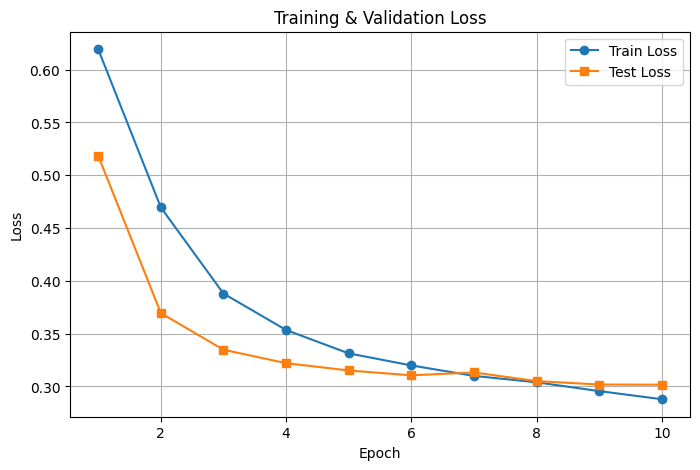

In [13]:
fcnn = FCNN(input_dim=X_train.shape[1], hidden_dim=64, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fcnn.parameters(), lr=0.001)

fcnn, train_losses, test_losses = train_model(fcnn, train_loader_fcnn, test_loader_fcnn, criterion, optimizer, num_epochs=10, device=device)

In [14]:
fcnn.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fcnn.to(device)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

with torch.no_grad():
    outputs = fcnn(X_test_tensor)           
    _, y_pred = torch.max(outputs, dim=1)  

y_true = y_test_tensor.cpu().numpy()
y_pred = y_pred.cpu().numpy()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['0', '1']))

Accuracy: 0.8858695652173914
Confusion Matrix:
 [[70 12]
 [ 9 93]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



# CNN

In [15]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)  
X_test_tensor  = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)  
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.long)

train_loader_cnn = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader_cnn  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [16]:
class CNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x shape: [batch, 1, num_features]
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pool(x)              # [batch, 64, 1]
        x = x.view(x.size(0), -1)     # flatten -> [batch, 64]
        x = self.fc(x)
        return x


Epoch [1/20] - Train Loss: 0.6804, Test Loss: 0.6662


Epoch [2/20] - Train Loss: 0.6615, Test Loss: 0.6311


Epoch [3/20] - Train Loss: 0.6287, Test Loss: 0.5840


Epoch [4/20] - Train Loss: 0.5816, Test Loss: 0.5355


Epoch [5/20] - Train Loss: 0.5443, Test Loss: 0.5047


Epoch [6/20] - Train Loss: 0.5241, Test Loss: 0.5016


Epoch [7/20] - Train Loss: 0.5226, Test Loss: 0.5121


Epoch [8/20] - Train Loss: 0.5062, Test Loss: 0.4894


Epoch [9/20] - Train Loss: 0.5010, Test Loss: 0.4755


Epoch [10/20] - Train Loss: 0.4914, Test Loss: 0.4652


Epoch [11/20] - Train Loss: 0.4837, Test Loss: 0.4667


Epoch [12/20] - Train Loss: 0.4738, Test Loss: 0.4661


Epoch [13/20] - Train Loss: 0.4779, Test Loss: 0.4639


Epoch [14/20] - Train Loss: 0.4712, Test Loss: 0.4347


Epoch [15/20] - Train Loss: 0.4678, Test Loss: 0.4349


Epoch [16/20] - Train Loss: 0.4502, Test Loss: 0.4274


Epoch [17/20] - Train Loss: 0.4372, Test Loss: 0.4218


Epoch [18/20] - Train Loss: 0.4310, Test Loss: 0.4159


Epoch [19/20] - Train Loss: 0.4210, Test Loss: 0.4034


Epoch [20/20] - Train Loss: 0.4172, Test Loss: 0.4056


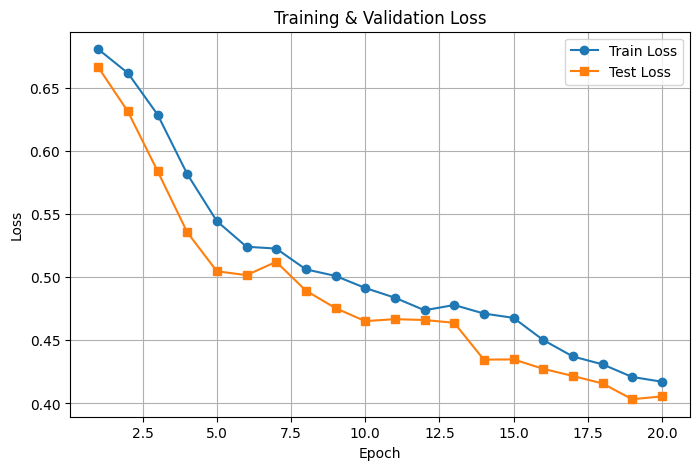

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = CNN(input_dim=X_train.shape[1], num_classes=len(y.unique()))
cnn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

cnn, train_losses, test_losses = train_model(cnn, train_loader_cnn, test_loader_cnn, criterion, optimizer, num_epochs=20, device=device)

In [18]:
cnn.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

with torch.no_grad():
    outputs = cnn(X_test_tensor)           
    _, y_pred = torch.max(outputs, dim=1)  

y_true = y_test_tensor.cpu().numpy()
y_pred = y_pred.cpu().numpy()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['0', '1']))

Accuracy: 0.8369565217391305
Confusion Matrix:
 [[70 12]
 [18 84]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82        82
           1       0.88      0.82      0.85       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



## ResNet

In [19]:
from torchvision.models import resnet18

In [20]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)  # [num_samples, 1, features]
X_test_tensor  = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [21]:
class ResNet(nn.Module):
    def __init__(self, num_features, num_classes):
        super(ResNet, self).__init__()
        # Load pretrained ResNet18
        self.model = resnet18(weights=None)  # weights=None for training from scratch
        # Change input channels to 1 instead of 3
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Replace final FC layer to match number of classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        # x shape: [batch, 1, features] -> reshape to [batch, 1, H, W] for ResNet
        x = x.unsqueeze(-1)  # [batch, 1, features, 1]
        return self.model(x)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(y.unique())
model = ResNet(num_features=X_train.shape[1], num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/30] - Train Loss: 0.7287, Test Loss: 0.6081


Epoch [2/30] - Train Loss: 0.4264, Test Loss: 0.3794


Epoch [3/30] - Train Loss: 0.3175, Test Loss: 0.3641


Epoch [4/30] - Train Loss: 0.2885, Test Loss: 0.4482


Epoch [5/30] - Train Loss: 0.2376, Test Loss: 0.4478


Epoch [6/30] - Train Loss: 0.2333, Test Loss: 0.5183


Epoch [7/30] - Train Loss: 0.2195, Test Loss: 0.5515


Epoch [8/30] - Train Loss: 0.1920, Test Loss: 0.5567
Early stopping at epoch 8


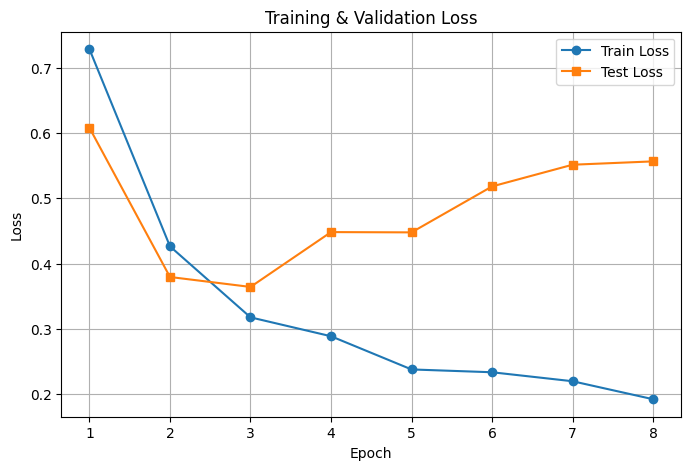

In [23]:
resnet, train_losses, test_losses = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=30, device=device, patience=5
)

In [24]:
resnet.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

with torch.no_grad():
    outputs = resnet(X_test_tensor)           
    _, y_pred = torch.max(outputs, dim=1)  

y_true = y_test_tensor.cpu().numpy()
y_pred = y_pred.cpu().numpy()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['0', '1']))

Accuracy: 0.8695652173913043
Confusion Matrix:
 [[74  8]
 [16 86]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86        82
           1       0.91      0.84      0.88       102

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184

